# Random forest fraction correct analysis
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Feature importance](#Feature-importance)

In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
print('Added to PYTHONPATH')

Added to PYTHONPATH


In [25]:
from __future__ import division
import argparse
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold

import composition as comp
import composition.analysis.plotting as plotting

# Plotting-related
sns.set_palette('muted')
sns.set_color_codes()
color_dict = defaultdict()
for i, composition in enumerate(['P', 'He', 'O', 'Fe', 'total']):
    color_dict[composition] = sns.color_palette('muted').as_hex()[i]
%matplotlib inline

## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [7]:
df_sim, cut_dict_sim = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]

df_sim = df_sim[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train_sim, X_test_sim, y_train_sim, y_test_sim, le = comp.get_train_test_sets(
    df_sim, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train_sim.shape[0]))
print('number testing events = ' + str(y_test_sim.shape[0]))

training features = ['lap_log_energy', 'InIce_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 145543
number testing events = 62376


In [10]:
df_data, cut_dict_data = comp.load_data(return_cut_dict=True)
selection_mask = np.array([True] * len(df_data))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict_data[key]

df_data = df_data[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
df_data = df_data.sample(frac=1).reset_index(drop=True)
X_test_data = df_data[feature_list].values

print('number testing events = ' + str(X_test_data.shape[0]))

training features = ['lap_log_energy', 'InIce_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number testing events = 31805


## Fit random forest and run 10-fold CV validation

In [4]:
pipeline = comp.get_pipeline('RF')
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
scores = cross_val_score(
    estimator=pipeline, X=X_train, y=y_train, cv=10, n_jobs=20)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

RandomForestClassifier
CV score: 42.71% (+/- 0.23%)


In [14]:
def get_comp_frac(X_train, X_test, y_train, comp_list):
    
    pipeline = comp.get_pipeline('RF')
    pipeline.fit(X_train, y_train)
    test_predictions = pipeline.predict(X_test)

    # Energy-related variables
    energy_bin_width = 0.1
    energy_bins = np.arange(6.2, 8.1, energy_bin_width)
    energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    log_energy = X_test[:, 0]

    # Get number of correctly identified comp in each reco energy bin
    num_reco_energy, num_reco_energy_err = {}, {}
    for composition in comp_list:
        num_reco_energy[composition] = np.histogram(
            log_energy[le.inverse_transform(test_predictions) == composition],
            bins=energy_bins)[0]
        num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

    num_reco_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
    num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])
    
    return num_reco_energy, num_reco_energy_err

## Compute systematic in fraction correct via CV

In [6]:
comp_list = ['P', 'He', 'O', 'Fe']
# Split data into training and test samples
kf = KFold(n_splits=10)
frac_correct_folds = defaultdict(list)
fold_num = 0
for train_index, test_index in kf.split(X_train):
    fold_num += 1
    print('Fold number {}...'.format(fold_num))
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    reco_frac, reco_frac_err = get_frac_correct(X_train_fold, X_test_fold,
                                                y_train_fold, y_test_fold,
                                                comp_list)
    for composition in comp_list:
        frac_correct_folds[composition].append(reco_frac[composition])
    frac_correct_folds['total'].append(reco_frac['total'])
frac_correct_sys_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}

Fold number 1...
Fold number 2...
Fold number 3...
Fold number 4...
Fold number 5...
Fold number 6...
Fold number 7...
Fold number 8...
Fold number 9...
Fold number 10...


/home/jbourbeau/cr-composition/composition/analysis/data_functions.py:11: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = ratio * np.sqrt((num_err / num)**2 + (den_err / den)**2)


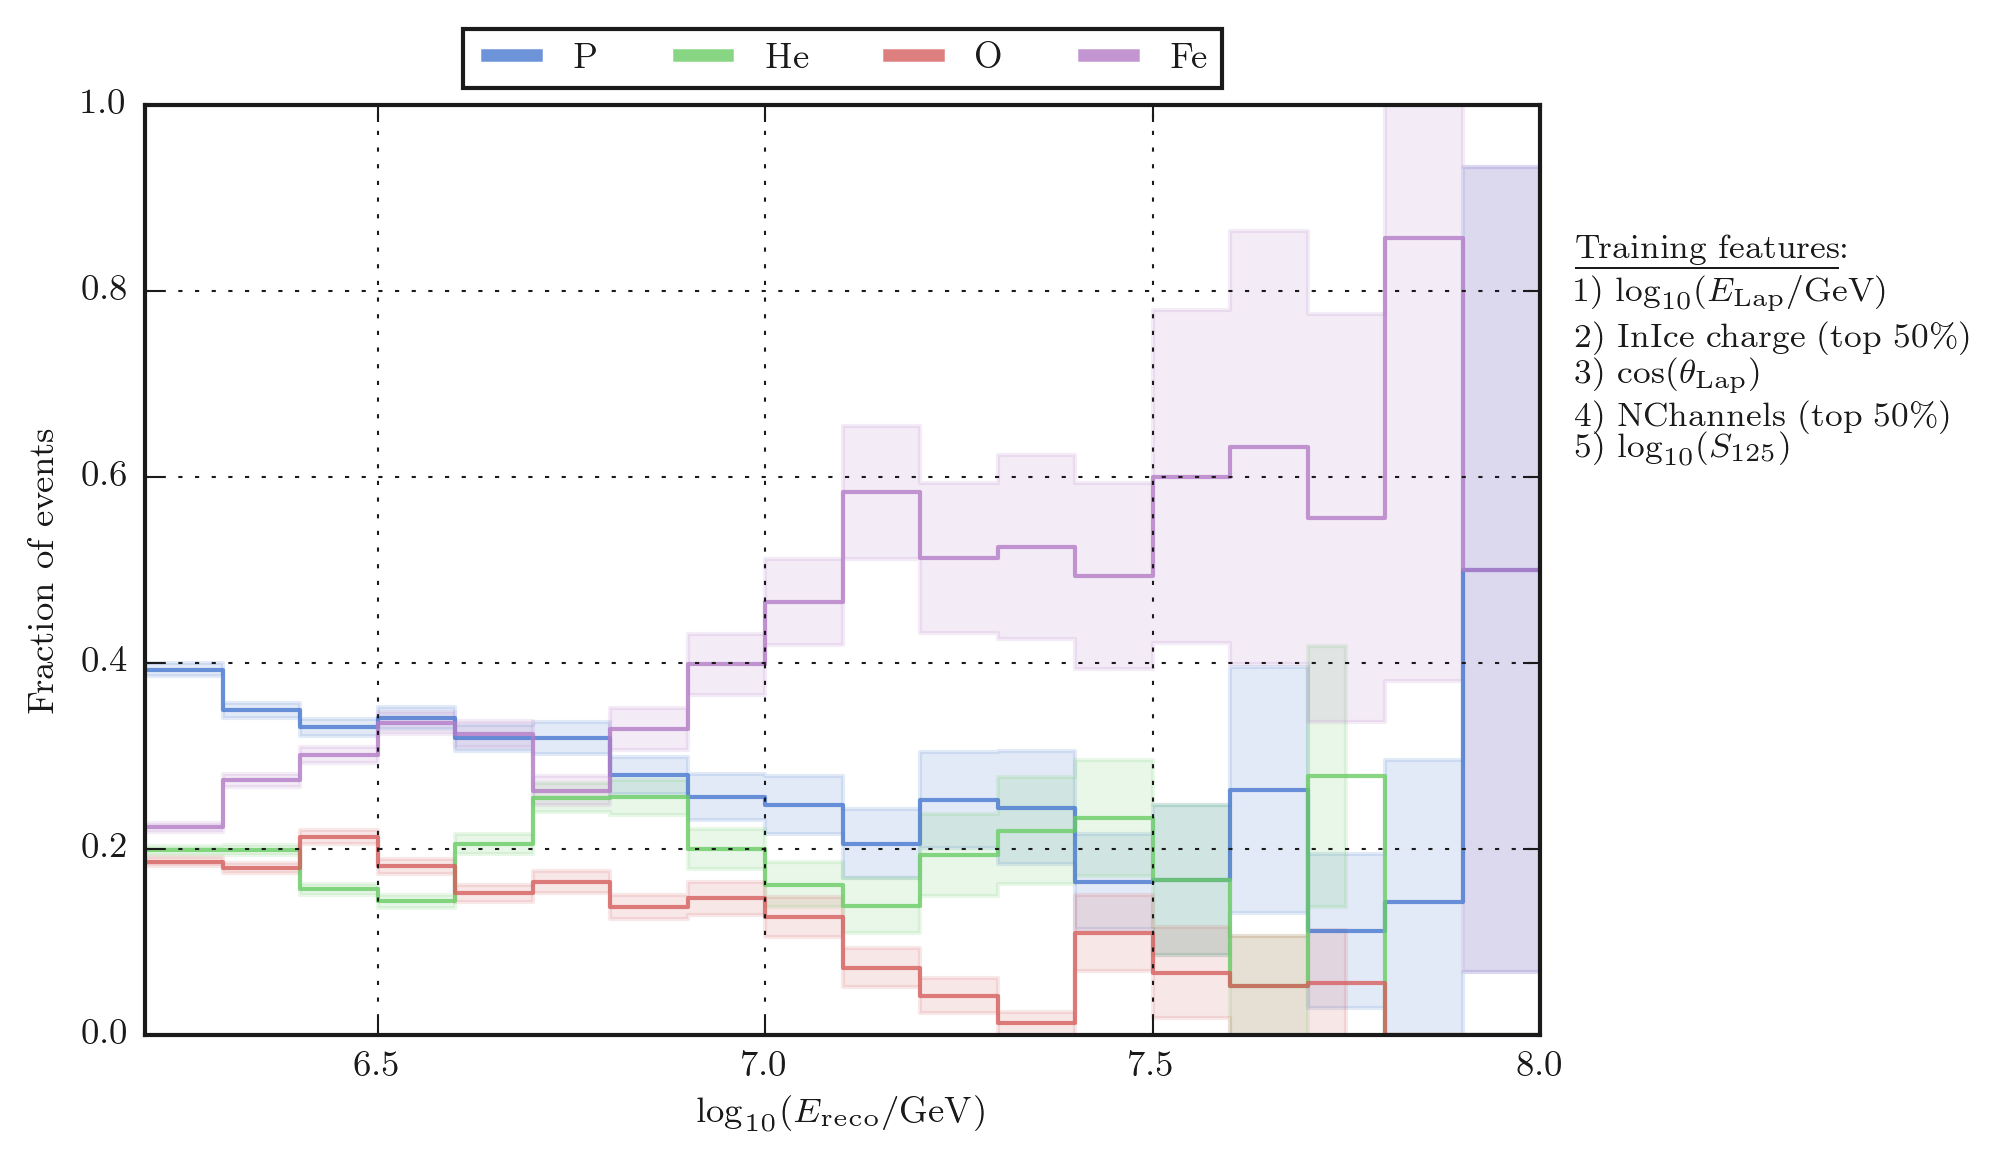

In [30]:
comp_list = ['P', 'He', 'O', 'Fe']
num_reco_energy, num_reco_energy_err = get_comp_frac(X_train_sim, X_test_data, y_train_sim, comp_list)
# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
step_x = energy_midpoints
step_x = np.append(step_x[0]-energy_bin_width/2, step_x)
step_x = np.append(step_x, step_x[-1]+energy_bin_width/2)
# Plot fraction of events vs energy
def plot_steps(x, y, y_err, ax, color, label):
    step_x = x
    x_widths = x[1:]-x[:-1]
    if len(np.unique(x_widths)) != 1:
        raise('Unequal bins...')
    x_width = np.unique(x_widths)[0]
    step_x = np.append(step_x[0]-x_width/2, step_x)
    step_x = np.append(step_x, step_x[-1]+x_width/2)
    
    step_y = y
    step_y = np.append(step_y[0], step_y)
    step_y = np.append(step_y, step_y[-1])
    
    err_upper = y + y_err
    err_upper = np.append(err_upper[0], err_upper)
    err_upper = np.append(err_upper, err_upper[-1])
    err_lower = y - y_err
    err_lower = np.append(err_lower[0], err_lower)
    err_lower = np.append(err_lower, err_lower[-1])
    
    ax.step(step_x, step_y, where='mid',
            marker=None, color=color, linewidth=1,
            linestyle='-', label=label, alpha=0.8)
    ax.fill_between(step_x, err_upper, err_lower,
                    alpha=0.15, color=color,
                    step='mid', linewidth=1)
    
    return step_x, step_y

fig, ax = plt.subplots()
for composition in comp_list:
    y, err = comp.ratio_error(
            num_reco_energy[composition], num_reco_energy_err[composition],
            num_reco_energy['total'], num_reco_energy_err['total'])
#     y = num_reco_energy[composition]/num_reco_energy['total']
#     err = num_reco_energy_err[composition]/num_reco_energy['total']
    plot_steps(energy_midpoints, y, err, ax, color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction of events')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
ax.grid()
leg = plt.legend(loc='upper center', 
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# place a text box in upper left in axes coords
textstr = '$\mathrm{\underline{Training \ features}}$: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
props = dict(facecolor='white', linewidth=0)
ax.text(1.025, 0.855, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
# cvstr = '$\mathrm{\underline{CV \ score}}$:\n' + '{:0.2f}\% (+/- {:.2}\%)'.format(scores.mean()*100, scores.std()*100)
# print(cvstr)
# props = dict(facecolor='white', linewidth=0)
# ax.text(1.025, 0.9825, cvstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)
plt.show()

training features = ['lap_log_energy' 'InIce_log_charge_1_30' 'lap_cos_zenith'
 'log_NChannels_1_30' 'log_s125' 'StationDensity' 'charge_nchannels_ratio'
 'stationdensity_charge_ratio']
number training events = 145543
number testing events = 62376


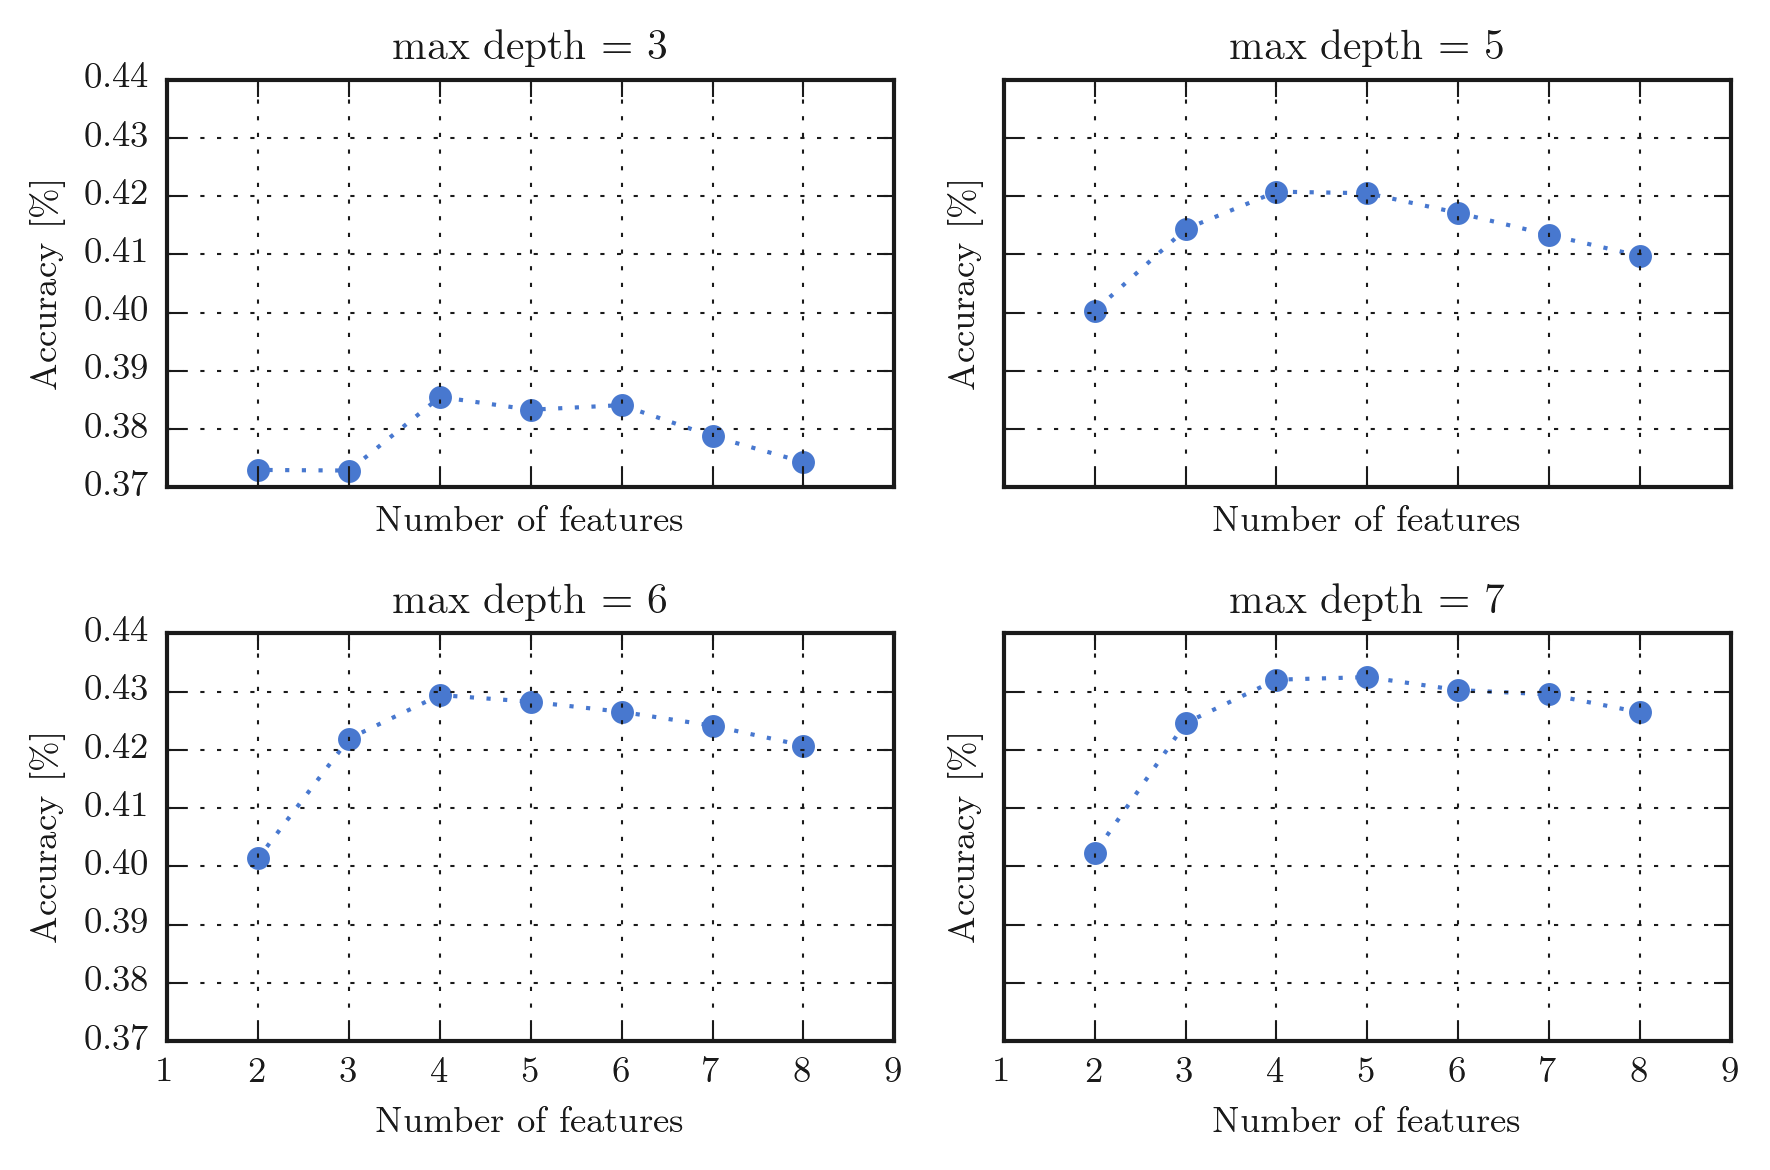

In [34]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

# feature_list, feature_labels = comp.get_training_features()
feature_list = np.array(['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith',
                         'log_NChannels_1_30', 'log_s125', 'StationDensity', 'charge_nchannels_ratio',
                         'stationdensity_charge_ratio'])
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=True, test_he=True)

print('number training events = ' + str(y_train.shape[0]))
print('number testing events = ' + str(y_test.shape[0]))

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
max_depth_list = [3, 5, 6, 7]
for max_depth, ax in zip(max_depth_list, axarr.flatten()):
    pipeline = comp.get_pipeline('RF')
    params = {'classifier__max_depth': max_depth}
    pipeline.set_params(**params)
    sbs = comp.analysis.SBS(pipeline, k_features=2)
    sbs.fit(X_train, y_train)

    # plotting performance of feature subsets
    k_feat = [len(k) for k in sbs.subsets_]

    ax.plot(k_feat, sbs.scores_, marker='.', linestyle=':')
    # plt.ylim([0.5, 1.1])
    ax.set_xlim([sorted(k_feat)[0]-1, sorted(k_feat)[-1]+1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of features')
    ax.set_title('max depth = {}'.format(max_depth))
    ax.grid()
plt.tight_layout()
plt.show()

In [35]:
print(sbs.subsets_)
print(len(feature_list))
gen = (feature_list[i] for i in sbs.subsets_)
for i in sbs.subsets_:
    print(', '.join(feature_list[np.array(i)]))
    print('\n')

[(0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 2, 3, 4, 5, 6), (0, 1, 2, 3, 4, 5), (0, 1, 2, 3, 4), (1, 2, 3, 4), (1, 3, 4), (3, 4)]
8
lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio, stationdensity_charge_ratio


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity, charge_nchannels_ratio


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125, StationDensity


lap_log_energy, InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125


InIce_log_charge_1_30, lap_cos_zenith, log_NChannels_1_30, log_s125


InIce_log_charge_1_30, log_NChannels_1_30, log_s125


log_NChannels_1_30, log_s125




In [27]:
feature_list[ np.array((0, 3, 4))]

array(['lap_log_energy', 'log_NChannels_1_30', 'log_s125'], 
      dtype='|S27')

## Feature importance

1) 0.398638682593
2) 0.280923821073
3) 0.171854679438
4) 0.117247572182
5) 0.0313352447147


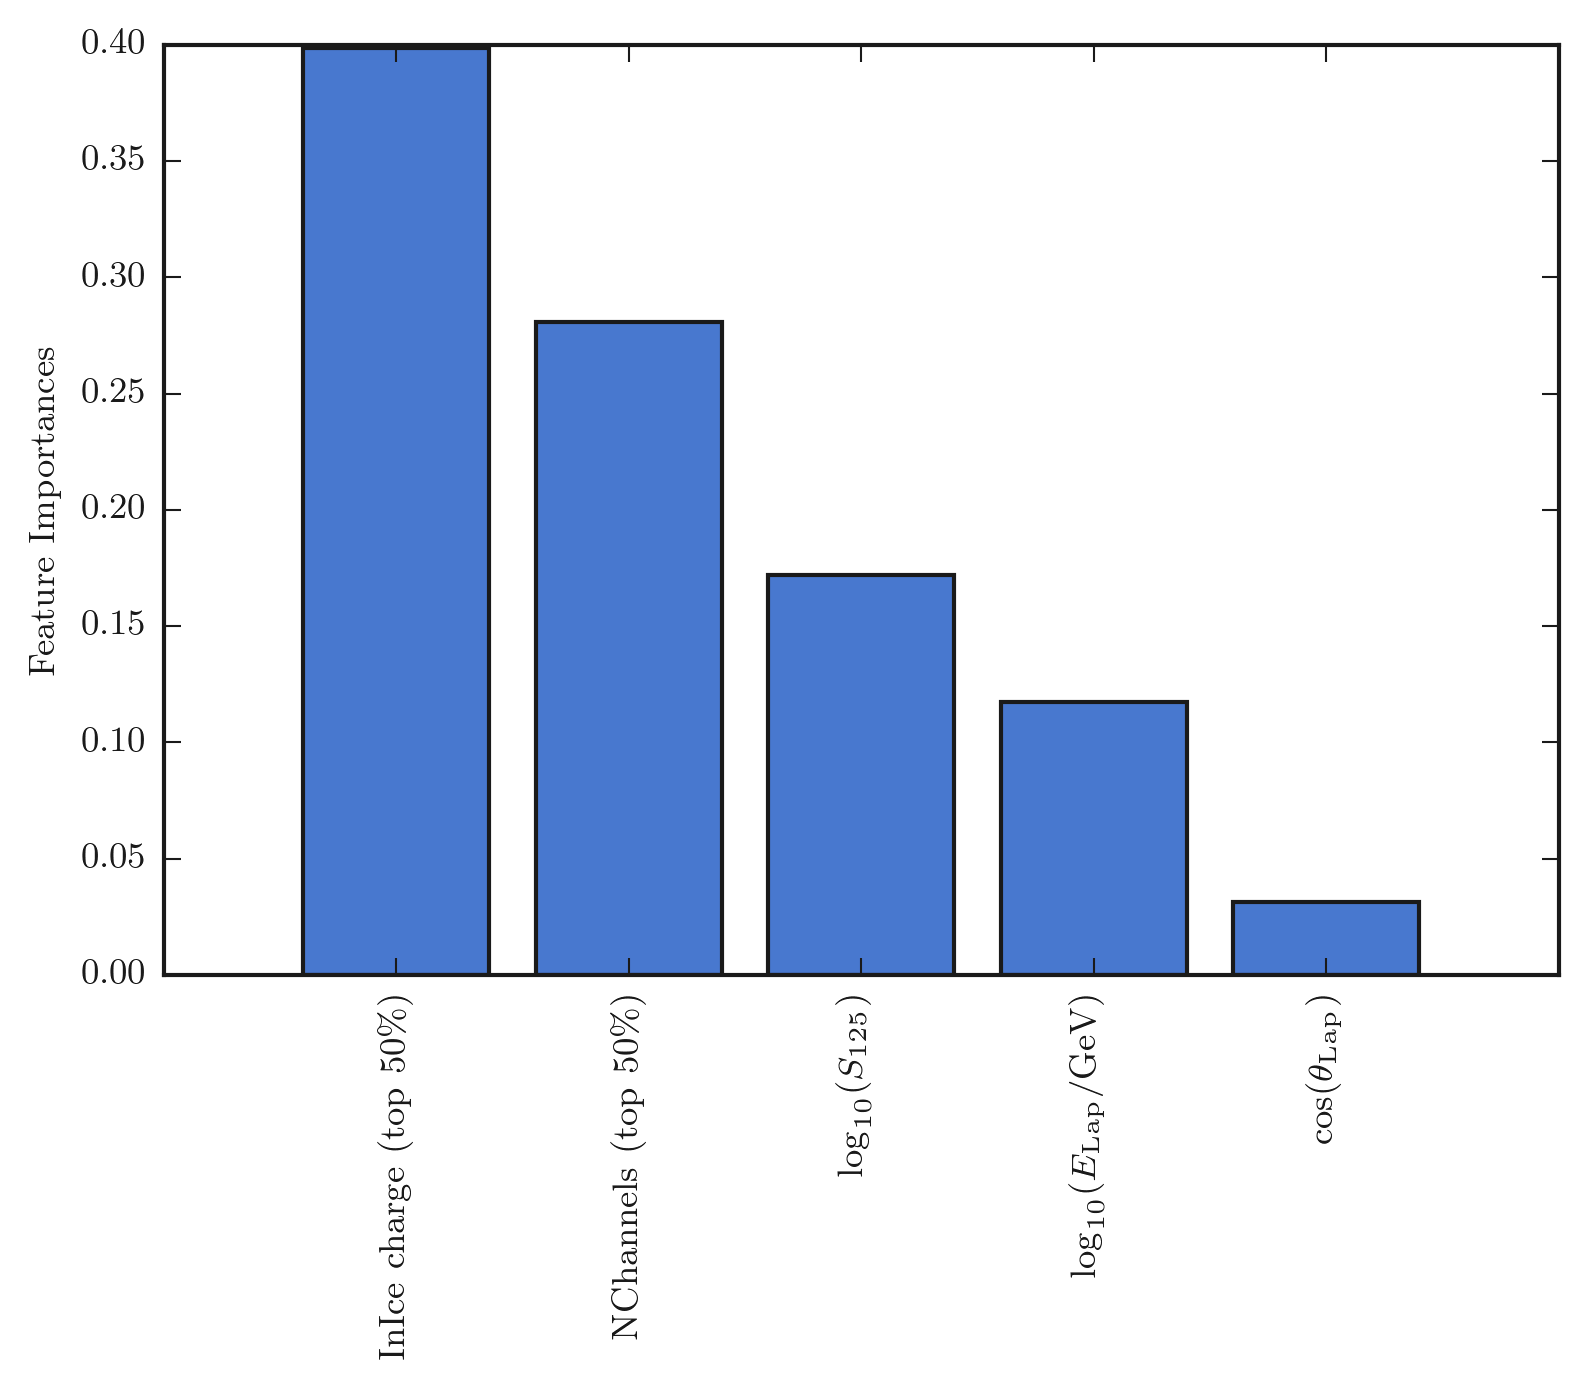

In [8]:
num_features = len(feature_list)
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)

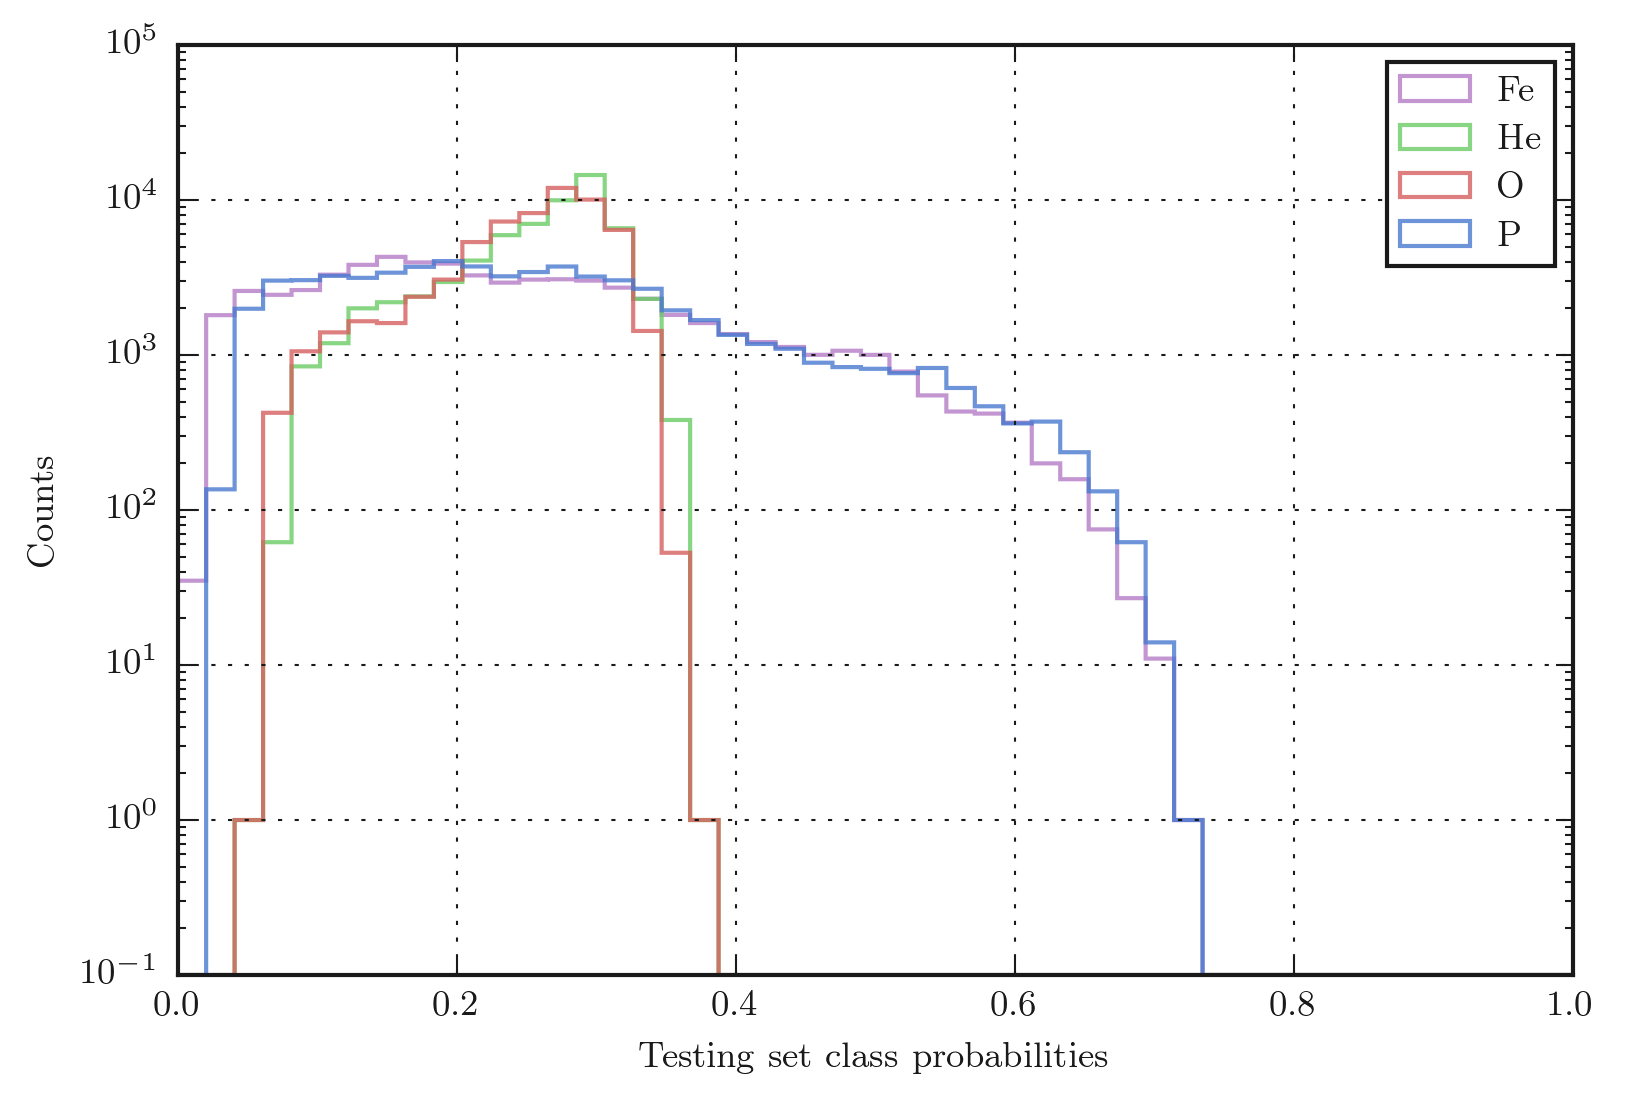

In [48]:
comp_list = ['P', 'He', 'O', 'Fe']
# test_probs = defaultdict(list)
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
for class_ in pipeline.classes_:
    composition = le.inverse_transform(class_)
    plt.hist(test_probs[:, class_], bins=np.linspace(0, 1, 50),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=True)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend()
plt.grid()
plt.show()

probs = (15883, 4)
min = 1.38011981318
max = 3.56902754108
probs = (15920, 4)
min = 1.40518894839
max = 3.5562126663
probs = (15507, 4)
min = 1.45593414673
max = 3.57278805564
probs = (15066, 4)
min = 1.50426220527
max = 3.60566706999


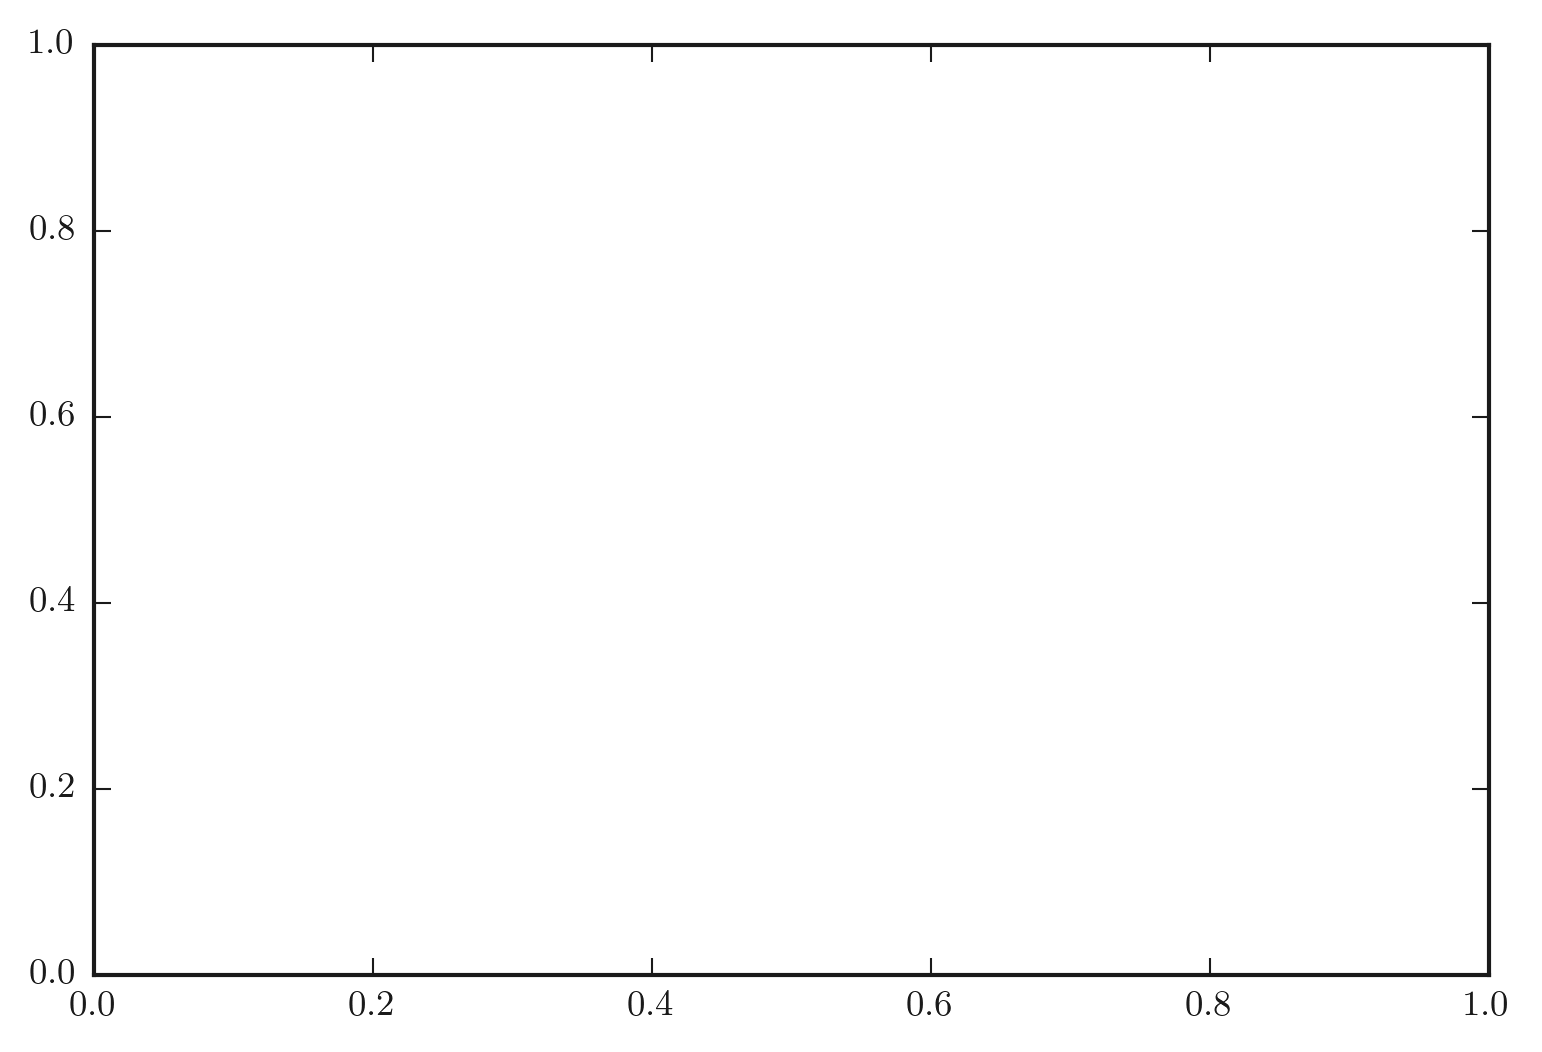

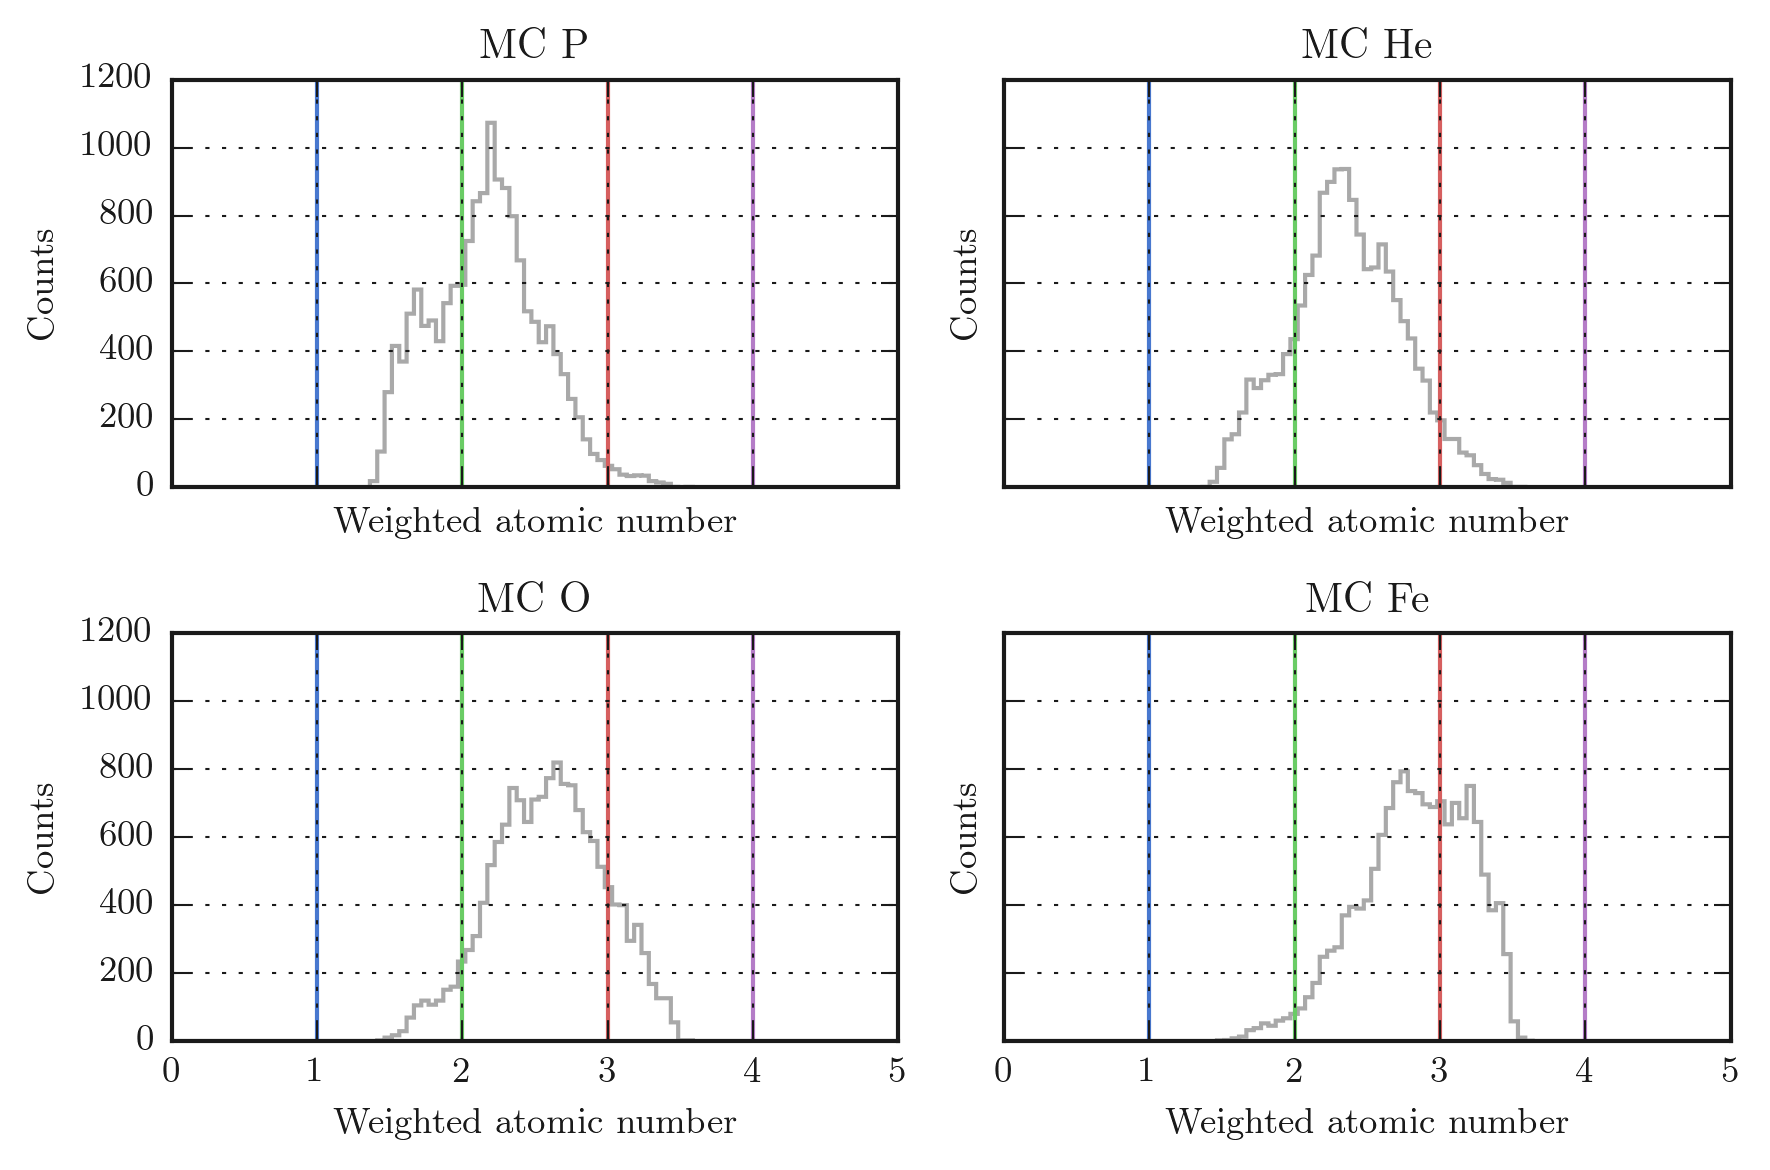

In [5]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    print('probs = {}'.format(probs.shape))
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        weighted_mass += comp.simfunctions.comp2mass(c) * probs[:, class_]
    print('min = {}'.format(min(weighted_mass)))
    print('max = {}'.format(max(weighted_mass)))
    ax.hist(weighted_mass, bins=np.linspace(0, 5, 100),
             histtype='step', label=None, color='darkgray',
             alpha=1.0, log=False)
    for c in comp_list:
        ax.axvline(comp.simfunctions.comp2mass(c), color=color_dict[c],
                   marker='None', linestyle='-')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Weighted atomic number')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

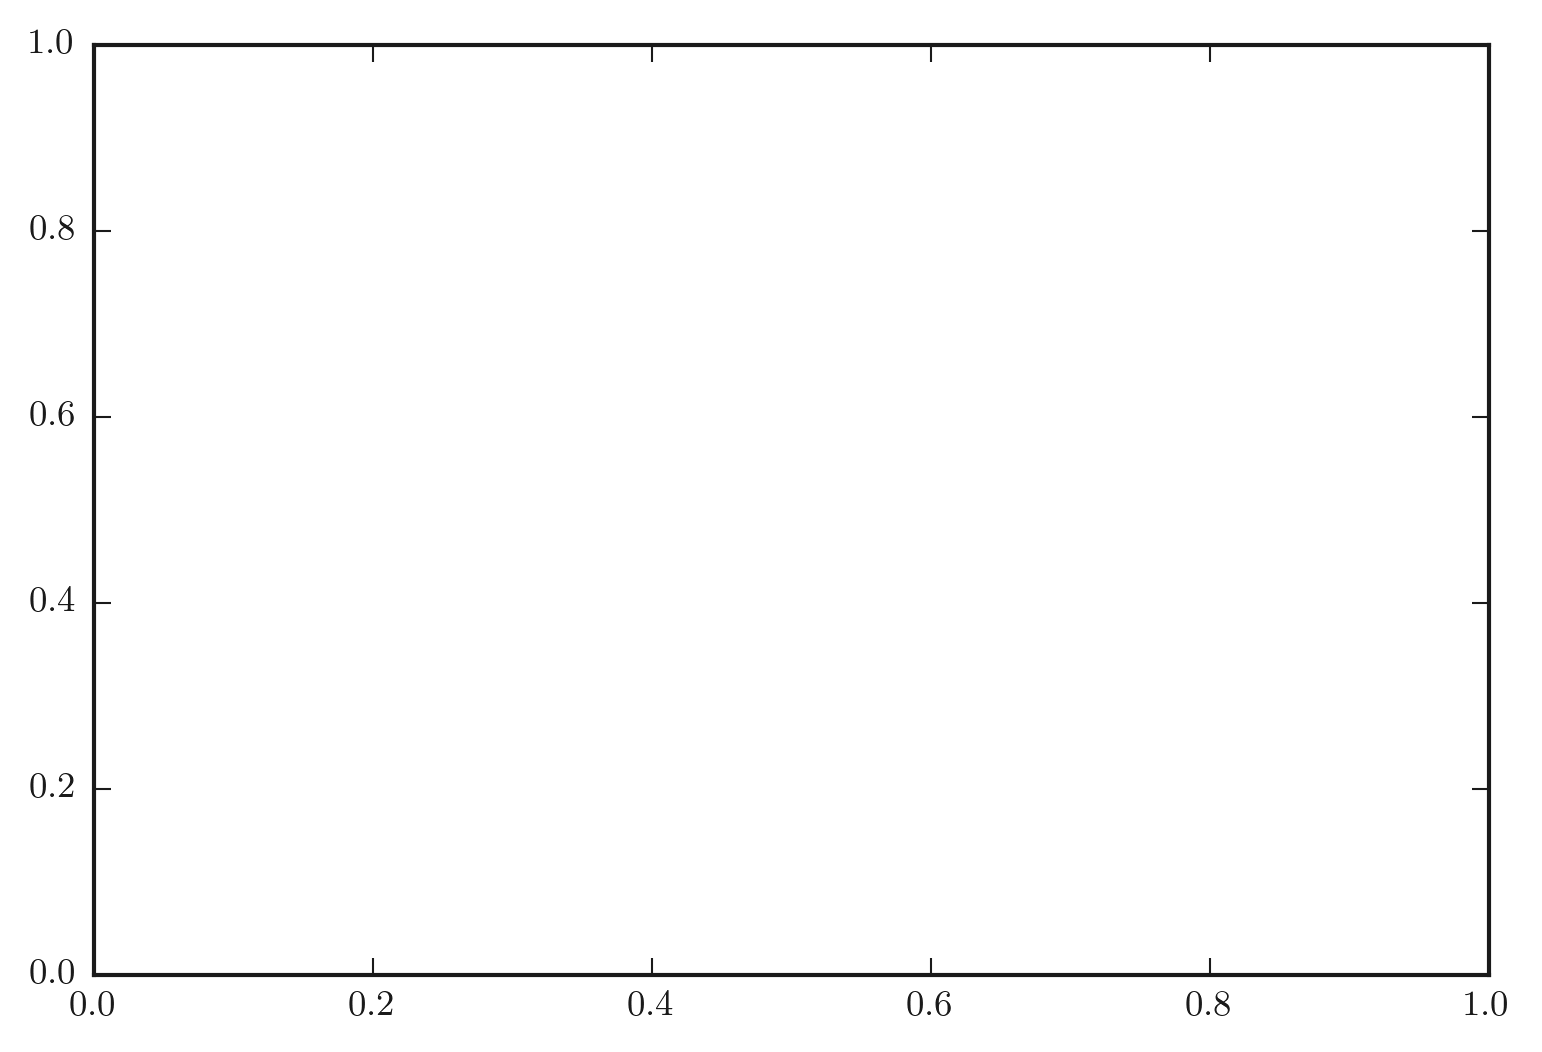

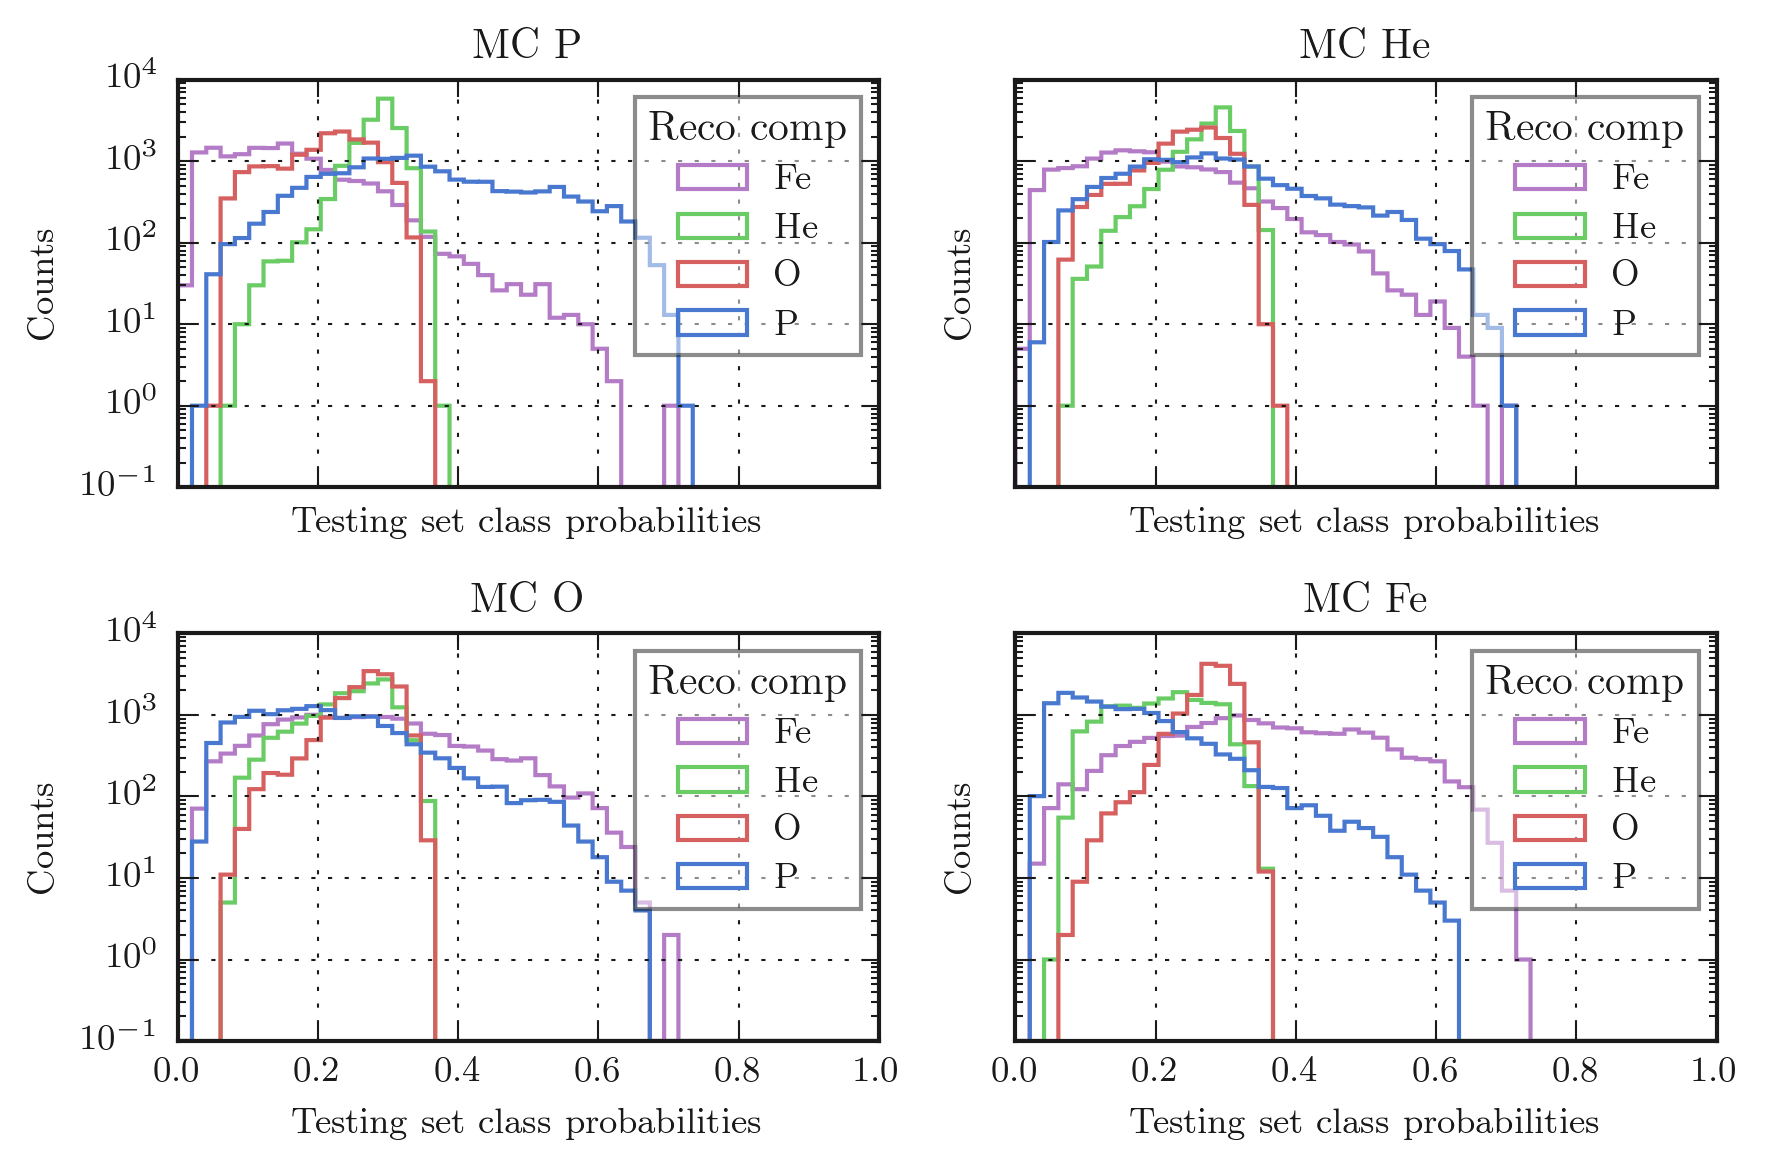

In [15]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
test_predictions = pipeline.predict(X_test)

comp_list = ['P', 'He', 'O', 'Fe']
fig, ax = plt.subplots()
test_probs = pipeline.predict_proba(X_test)
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
for composition, ax in zip(comp_list, axarr.flatten()):
    comp_mask = (le.inverse_transform(y_test) == composition)
    probs = np.copy(test_probs[comp_mask])
    weighted_mass = np.zeros(len(probs))
    for class_ in pipeline.classes_:
        c = le.inverse_transform(class_)
        ax.hist(probs[:, class_], bins=np.linspace(0, 1, 50),
                 histtype='step', label=c, color=color_dict[c],
                 alpha=1.0, log=True)
    ax.legend(title='Reco comp', framealpha=0.5)
    ax.set_ylabel('Counts')
    ax.set_xlabel('Testing set class probabilities')
    ax.set_title('MC {}'.format(composition))
    ax.grid()
plt.tight_layout()
plt.show()

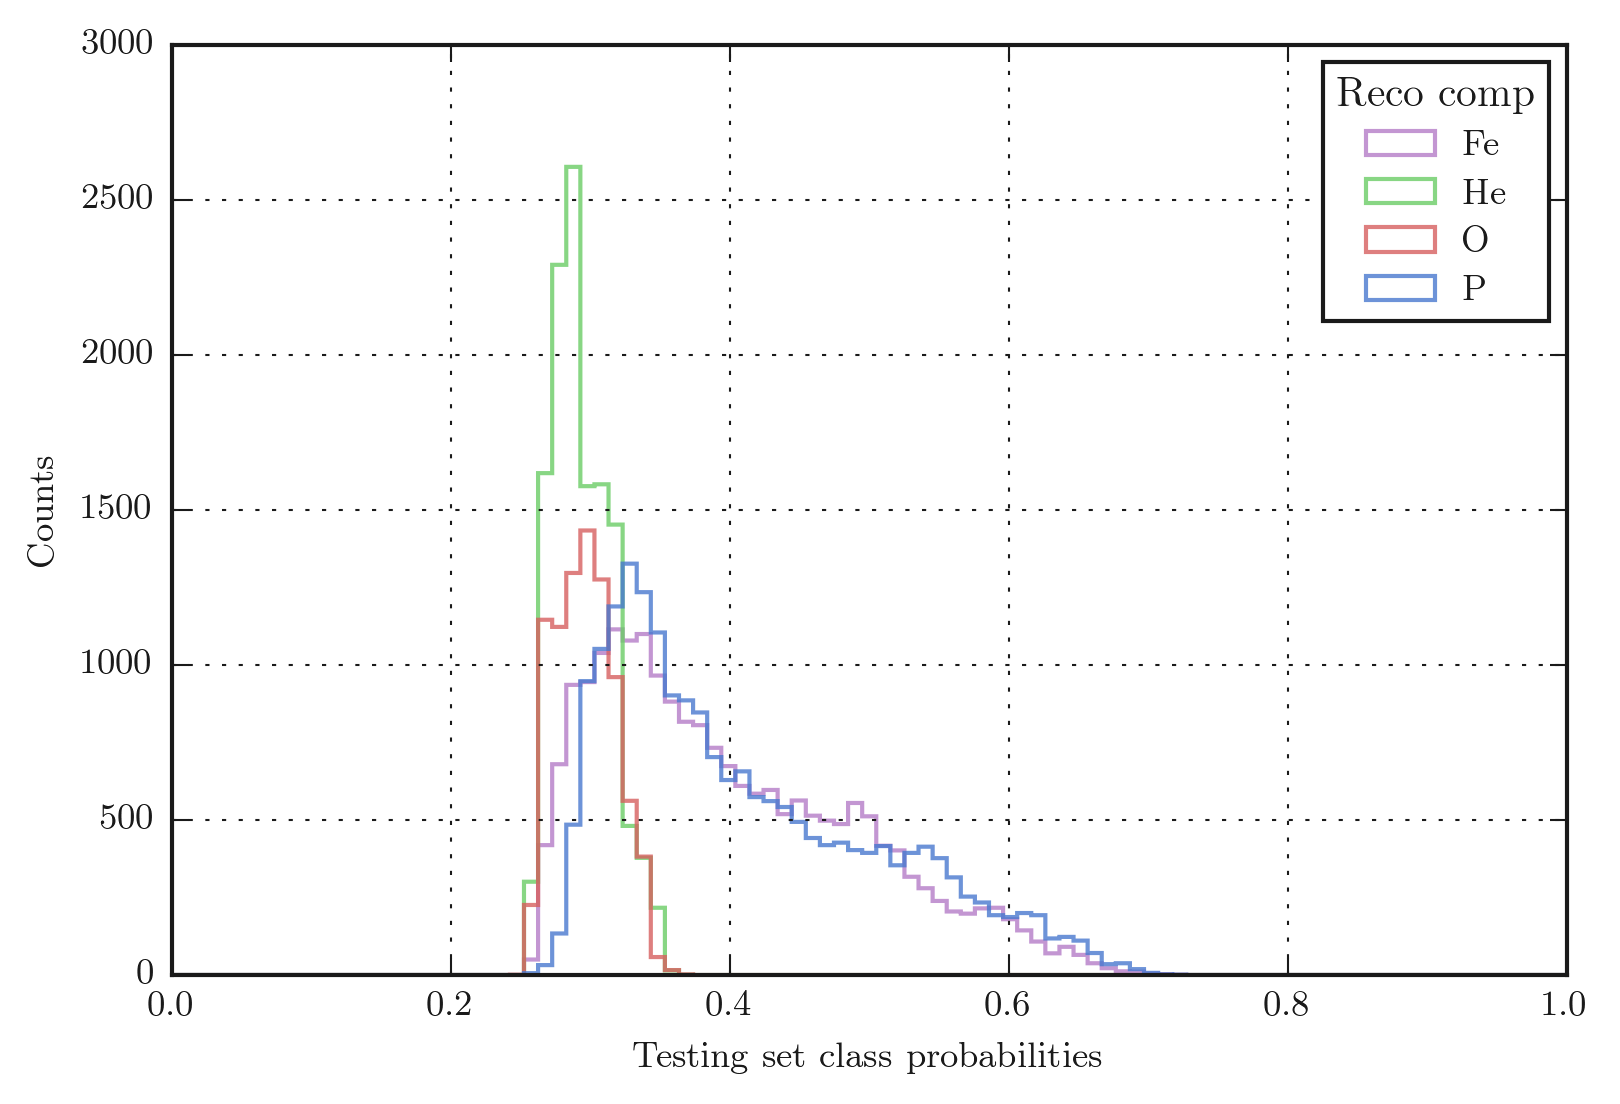

In [50]:
comp_list = np.unique(df['MC_comp'])
test_probs = defaultdict(list)
fig, ax = plt.subplots()
# test_probs = pipeline.predict_proba(X_test)
for event in pipeline.predict_proba(X_test):
    composition = le.inverse_transform(np.argmax(event))
    test_probs[composition].append(np.amax(event))
for composition in comp_list:
    plt.hist(test_probs[composition], bins=np.linspace(0, 1, 100),
             histtype='step', label=composition,
             color=color_dict[composition], alpha=0.8, log=False)
plt.ylabel('Counts')
plt.xlabel('Testing set class probabilities')
plt.legend(title='Reco comp')
plt.grid()
plt.show()